In [6]:
!pip install bioio==3.0.0 bioio-czi==2.4.0 bioio-ome-tiff==1.4.0

In [3]:
!pip install matplotlib==3.10.5
!pip install seaborn==0.13.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 12.6 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0


In [1]:
!pip install cellpose==4.0.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.8 MB/s eta 0:00:00


In [3]:
!pip uninstall torch
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu128

Found existing installation: torch 2.8.0+cu126
Uninstalling torch-2.8.0+cu126:
  Would remove:
    /usr/local/bin/torchfrtrace
    /usr/local/bin/torchrun
    /usr/local/lib/python3.12/dist-packages/functorch/*
    /usr/local/lib/python3.12/dist-packages/torch-2.8.0+cu126.dist-info/*
    /usr/local/lib/python3.12/dist-packages/torch/*
    /usr/local/lib/python3.12/dist-packages/torchgen/*
Proceed (Y/n)? Y
  Successfully uninstalled torch-2.8.0+cu126
Looking in indexes: https://download.pytorch.org/whl/cu128
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 889.0/889.0 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 7.9 MB/s eta 0:00:00
   ━━━━━━

In [9]:


from bioio import BioImage
import numpy as np



In [11]:
image_path = "/content/hela_prolongdiamond_dapi_tubulin-af488_mitochondria-af568_40x.czi"


# Get a BioImage object
img = BioImage(image_path)  # selects the first scene found

print("img shape: {}".format(img.shape))
print("Dimension order: {}".format(img.dims.order))

image_scale = [img.physical_pixel_sizes.Z, img.physical_pixel_sizes.Y, img.physical_pixel_sizes.X]
print("Dimension order: {}".format(image_scale))

color_map = 'cyan'

nuclei_cell_image = img.get_image_data("CZYX", T=0)[[1, 2], :, :, :].squeeze()

img shape: (1, 3, 14, 512, 512)
Dimension order: TCZYX
Dimension order: [1.0, 0.4151329104819196, 0.4151329104819196]


In [12]:


anisotropy = img.physical_pixel_sizes.Z / img.physical_pixel_sizes.X
print("Anisotropy (Z/X): {:.2f}".format(anisotropy))



Anisotropy (Z/X): 2.41


In [13]:


print("nuclei_cell_image shape: {}".format(nuclei_cell_image.shape))

#nuclei_cell_image_2d = nuclei_cell_image.squeeze()
#nuclei_cell_image_2d=nuclei_cell_image_2d.transpose(1, 0, 2,3)
#print(nuclei_cell_image_2d.shape)
#nuclei_cell_image_2d= np.max(nuclei_cell_image_2d, axis=0)
#print("img shape: {}".format(nuclei_cell_image_2d.shape))
nuclei_cell_image_MIP= np.max(nuclei_cell_image, axis=1)
print("nuclei_cell_image MIP shape: {}".format(nuclei_cell_image_MIP.shape))



nuclei_cell_image shape: (2, 14, 512, 512)
nuclei_cell_image MIP shape: (2, 512, 512)


In [14]:


from cellpose import models


model = models.CellposeModel(gpu=True)





Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.6 
platform:       	linux 
python version: 	3.12.11 
torch version:  	2.8.0+cu128! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




100%|██████████| 1.15G/1.15G [00:25<00:00, 48.3MB/s]


In [15]:


from cellpose import models

# Initialize model with GPU support based on argument
#model = models.CellposeModel(gpu=True)

#define the parameters
diameter = 60 # in pixels, set to 0 to let the model estimate the diameter
channel_axis = 0 # first axis is the channel axis
do_3D = False # enable 3D processing
anisotropy = anisotropy # anisotropy of the dataset
cellprob_threshold = 0.0 # all pixels with value above threshold kept for masks, decrease to find more and larger masks. Defaults to 0.0.
flow_threshold = 0.4 #if do_3D and flow3D_smooth>0, smooth flows with gaussian filter of this stddev. Defaults to 0.

# Run segmentation with 2D
masks, flows, styles = model.eval(
    nuclei_cell_image_MIP,
    diameter=diameter,
    channel_axis=channel_axis,
    do_3D=do_3D,
    anisotropy=anisotropy,
    cellprob_threshold=cellprob_threshold,
    flow_threshold=flow_threshold,
)



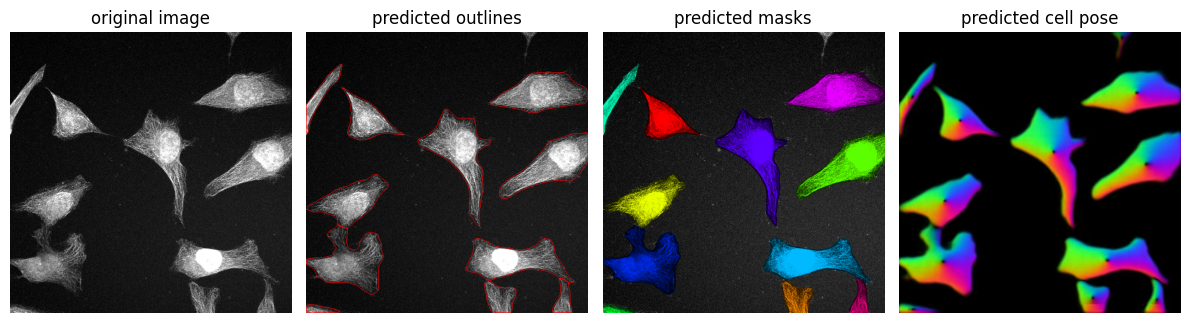

In [16]:


%matplotlib inline
import matplotlib.pyplot as plt
from cellpose import plot

channels = [0,1]
fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, nuclei_cell_image_MIP.squeeze(), masks, flows[0], channels=channels)
plt.tight_layout()
plt.show()



In [19]:


import bioio_base as biob
from bioio_ome_tiff.writers import OmeTiffWriter
import os

output_path="/content/c1-c2.ome.tiff"

write_dim_order = "CZYX"  # required, the dimension order to write the data in
channel_names = ['Tubulin', 'DAPI']
channel_colors = [(0,255,0), (0,255,255)]  # Magenta/Green/Cyam, colors in RGB format
pixel_size = biob.types.PhysicalPixelSizes(img.physical_pixel_sizes.Z, img.physical_pixel_sizes.Y, img.physical_pixel_sizes.X)  # optional, Z, Y, X in microns


OmeTiffWriter.save(
        nuclei_cell_image,
        output_path,
        write_dim_order,
        channel_names=channel_names,
        channel_colors=channel_colors,
        physical_pixel_sizes=pixel_size,
    )



In [20]:


from skimage.segmentation import watershed, relabel_sequential
from scipy import ndimage as ndi
from skimage.morphology import isotropic_erosion, remove_small_objects



cyto_threshold_value = 200

nuclei = img.get_image_data("CZYX", T=0, C=2).squeeze()
cytoplasm = img.get_image_data("CZYX", T=0, C=1).squeeze()



In [21]:


import numpy as np
from skimage import io, filters, exposure, morphology, measure
from scipy.ndimage import gaussian_filter
from skimage import data, restoration, util

# 1. Background subtraction (rolling ball in ImageJ)
# scikit-image does not have rolling ball natively, but we can approximate
# using morphological opening with a large ball-shaped structuring element.
from skimage.morphology import ball


image_bg_sub = np.empty_like(nuclei, dtype=np.uint16)

for z in range(nuclei.shape[0]):
    background = restoration.rolling_ball(nuclei[z], radius=70)
    image_bg_sub[z] = nuclei[z] - background
    image_bg_sub[z] = np.clip(image_bg_sub[z], 0, None)



In [22]:


print(image_bg_sub.shape)
print(image_bg_sub.dtype)
print("Minimum: {}, Maximum: {}".format(np.min(image_bg_sub), np.max(image_bg_sub)))



(14, 512, 512)
uint16
Minimum: 0, Maximum: 2095


In [23]:


# 2. CLAHE (Contrast Limited Adaptive Histogram Equalization)
image_clahe = exposure.equalize_adapthist(image_bg_sub,
                                          kernel_size=127,
                                          clip_limit=0.03)  # adjust clip_limit to match ImageJ



In [24]:


print(image_clahe.shape)
print(image_clahe.dtype)
print("Minimum: {}, Maximum: {}".format(np.min(image_clahe), np.max(image_clahe)))



(14, 512, 512)
float64
Minimum: 0.0, Maximum: 1.0


In [26]:
image_blur = gaussian_filter(image_clahe, sigma=3)

In [27]:


print(image_blur.shape)
print(image_blur.dtype)
print("Minimum: {}, Maximum: {}".format(np.min(image_blur), np.max(image_blur)))



(14, 512, 512)
float64
Minimum: 0.019029560269889945, Maximum: 0.6589044097926322


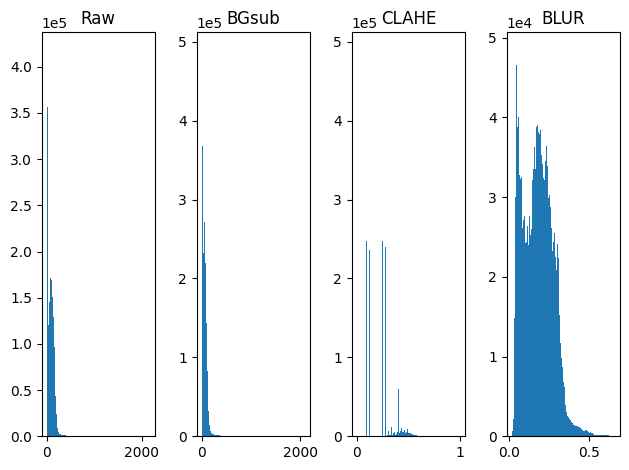

In [28]:


from matplotlib import pyplot as plt

from skimage import (exposure, feature, filters, io, measure,
                      morphology, restoration, segmentation, transform,
                      util)

# Helper function for plotting histograms.
def plot_hist(ax, data, title=None):
    ax.hist(data.ravel(), bins=256)
    ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))

    if title:
        ax.set_title(title)

fig, ((a, b, c, d)) = plt.subplots(nrows=1, ncols=4)

plot_hist(a, nuclei, title="Raw")
plot_hist(b, image_bg_sub, title="BGsub")
plot_hist(c, image_clahe, title="CLAHE")
plot_hist(d, image_blur, title="BLUR")

fig.tight_layout()

